# Logistics Optimization

In [16]:
%reload_ext autoreload
%autoreload 2
%reload_ext blackcellmagic
%matplotlib inline

In [17]:
import collections
import json

import math 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from relearn.env import SimpleLogistics, Warehouse

# Logistics Provider Environment

Every day, items are dispatched from sellers to the distribution center. Our logistics provider delivers some of items to their final destinations.

To make the problem simpler, we made following assumptions:
- We consider only one logistics provider with a single distribution center.
- If inventory is full, new items cannot be dispatched.
- There is late delivery penalty.
- Items of the same destination are grouped and shipped together.

> TODOs:
In this first draft, the environment doesn't consider the route-optimization and use the route list (the costs between the distribution center and the destinations).
As the next step, the list should be extended to a matrix denoting the route costs (distance and traffic) between all the two points. The agent's action.item_delivery will be the ordered list where the position of the items are the delivery order.

Limitations:
* No limit for the number of items per delivery --> TODO should implement delivery capacity to make the problem non-trivial
* No penalty for rejected items during dispatch
* Static delivery fee

In [62]:
NUM_EPISODES = 100
NUM_LOCATIONS = 10
WAREHOUSE_CAPACITY = 100

SEED = 1234

In [66]:
env = SimpleLogistics(
    T=NUM_EPISODES,
    capacity=WAREHOUSE_CAPACITY,
    num_locations=NUM_LOCATIONS,
    seed=SEED,
)
env.render()

/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


,time,dest,due,price,penalty
0,0.0,7.0,2.0,0.5,0.25
1,0.0,0.0,2.0,0.5,0.25
2,0.0,9.0,2.0,0.5,0.25
3,0.0,1.0,2.0,0.5,0.25
4,0.0,5.0,2.0,0.5,0.25
...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.00
96,0.0,0.0,0.0,0.0,0.00
97,0.0,0.0,0.0,0.0,0.00
98,0.0,0.0,0.0,0.0,0.00


Text(0, 0.5, 'Demand')

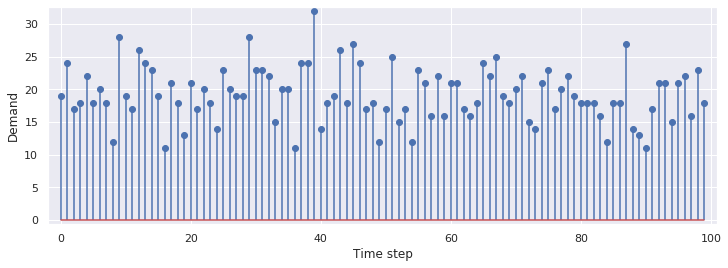

In [67]:
# Visualize demand functions
env.reset(SEED)
plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.stem([len(env.demand()) for _ in range(NUM_EPISODES)], use_line_collection=True)
plt.xlabel("Time step")
plt.ylabel("Demand")

In [74]:
env.warehouse.delivery_map

array([0.19151945, 0.62210877, 0.43772774, 0.78535858, 0.77997581,
       0.27259261, 0.27646426, 0.80187218, 0.95813935, 0.87593263])

In [79]:
# Sample action
env.action_space.sample()

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int8)

Text(0, 0.5, 'Profit')

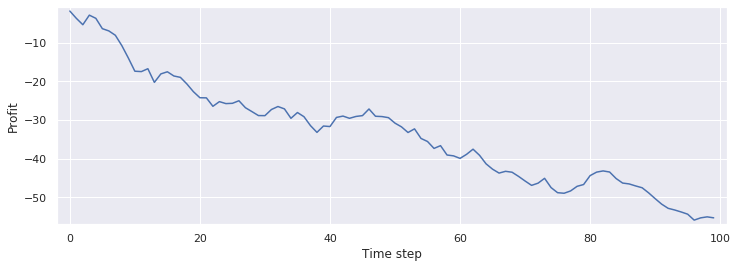

In [80]:
# Random action
env.reset(SEED)
done = False
rewards = []
while not done:
    _, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

Text(0, 0.5, 'Profit')

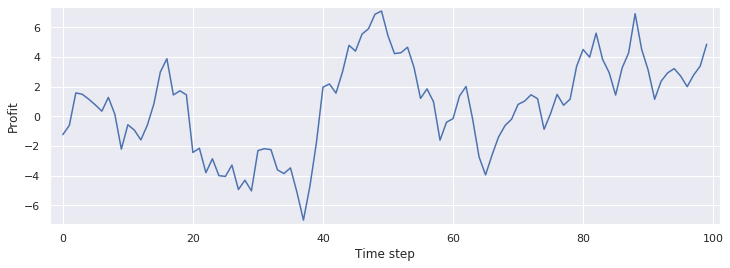

In [87]:
# First come first serve
env.reset(SEED)
done = False
rewards = []
while not done:
    _, reward, done, info = env.step([1]*len(env.warehouse.inventory))
    rewards.append(reward)

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

In [88]:
env.close()

In [ ]:
# TODO seed for reproducibility
# TODO plot demands, delivery, penalty, etc. together


# Baseline Policy

In [ ]:
# We use (s, Q)-policy as a baseline 
# The policy is: Order your Economic Order Quantity Q, every time your inventory 
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
        else: 
            action.production_level = 0
        return action
    
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process 
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

### Optimizing (s, Q)-policy parameters using Facebook Ax

In [ ]:
from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'], 
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },  
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=200,
    )

In [ ]:
display(best_parameters)
display(best_values)

In [ ]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

In [ ]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

### Optimization of (s, Q)-policy parameters using brute force search

In [ ]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [ ]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray import tune
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}
    
ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512] 
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000
    
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(200):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

train_ddpg()

# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = ".../ray_results/DDPG_SimpleSupplyChain_2020-01-23_20-51-479cn5z0i0" # this path needs to be set manually
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))